In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

from music_data_analysis import Pianoroll
import torch
from torch import Tensor

import matplotlib.pyplot as plt
from diff_music.data.dataset import PianorollDataset

from pathlib import Path

from diff_music.models.midilike_transformer import MidiLikeTransformer

# ds_path = Path(r'W:\music\music-data-analysis\data')
ds_path = Path('W:/piano-ai/pop80k_k')
ds = PianorollDataset(ds_path, frames_per_beat=8, length=32*4)


PianorollDataset initialized with 20078 segments from 2570 songs


In [3]:
from torch.utils.data import DataLoader

from diff_music.models.midilike_transformer import collate_fn
from dataclasses import dataclass

@dataclass
class TrainingParams:
    batch_size: int
    learning_rate: float
    num_epochs: int
    num_workers: int
    generate_steps: int

training_params = TrainingParams(
    batch_size=32,
    learning_rate=1e-4,
    num_epochs=100,
    num_workers=10,
    generate_steps=200,
)

dataloader = DataLoader(ds, batch_size=training_params.batch_size, shuffle=True, drop_last=True, collate_fn=collate_fn, num_workers=training_params.num_workers, persistent_workers=training_params.num_workers > 0)

In [4]:


device = torch.device('cuda')


model_params = MidiLikeTransformer.Params(
    hidden_dim=512,
    num_layers=4,
    pitch_range=[21, 109],
    max_len=1024
)
model = MidiLikeTransformer(model_params)
model.to(device)


optim = torch.optim.Adam(model.parameters(), lr=training_params.learning_rate)

In [5]:
from datetime import datetime
import wandb
run = wandb.init(
    # Set the project where this run will be logged
    project="vqpiano",
    group="midilike-scratch",
    id=datetime.now().strftime("%Y%m%d_%H%M%S"),
    # Track hyperparameters and run metadata
    config={
        "ds_path": ds_path,
        "training": training_params,
        "model": model_params,
    },
)
step = 0

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: eri24816 (tanchihpin0517-team) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [6]:
from tqdm import tqdm
import torch_util.wandb

for epoch in range(training_params.num_epochs):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}")
    for token, token_type, pos in pbar:
        model.train()

        token = token.to(device)
        token_type = token_type.to(device)
        pos = pos.to(device)

        loss = model.calculate_loss(token, token_type, pos)
        
        optim.zero_grad()
        loss.total_loss.backward()
        optim.step()

        pbar.set_postfix(loss=loss.total_loss.item(), pitch_loss=loss.pitch_loss.item(), token_type_loss=loss.token_type_loss.item(), pitch_acc=loss.pitch_acc, token_type_acc=loss.token_type_acc)
        wandb.log({
            "loss": loss.total_loss.item(),
            "pitch_loss": loss.pitch_loss.item(),
            "token_type_loss": loss.token_type_loss.item(),
            "pitch_acc": loss.pitch_acc,
            "token_type_acc": loss.token_type_acc,
        }, step=step)

        if (step % training_params.generate_steps == 0):
            model.eval()
            pr = model.sample_midi(128)
            torch_util.wandb.log_midi_as_audio(pr.to_midi(), 'audio', step)
            torch_util.wandb.log_image(pr.to_tensor().t().flip(0), 'pr', step)

        
        step += 1
        

Epoch 2:  84%|████████▍ | 528/627 [01:55<00:21,  4.56it/s, loss=0.79, pitch_acc=0.103, pitch_loss=0.534, token_type_acc=0.892, token_type_loss=0.256]  


KeyboardInterrupt: 

In [ ]:
pr.to_tensor().shape

torch.Size([128, 88])

In [47]:
model.eval()
pr = model.sample_midi(128)
pr.to_midi('sample.mid')
len(pr.notes)

100%|██████████| 128/128 [00:00<00:00, 140.88it/s]


78

In [39]:
model.device = torch.device('cuda')

In [38]:
token[0]

tensor([[ 0,  0],
        [34, 47],
        [51, 61],
        [53, 63],
        [58, 67],
        [ 0,  0],
        [ 0,  0],
        [ 0,  0],
        [ 0,  0],
        [41, 50],
        [ 0,  0],
        [ 0,  0],
        [46, 58],
        [ 0,  0],
        [ 0,  0],
        [58, 69],
        [ 0,  0],
        [ 0,  0],
        [ 0,  0],
        [ 0,  0],
        [41, 55],
        [ 0,  0],
        [ 0,  0],
        [46, 65],
        [ 0,  0],
        [ 0,  0],
        [58, 58],
        [65, 75],
        [69, 83],
        [ 0,  0],
        [63, 58],
        [ 0,  0],
        [ 0,  0],
        [ 0,  0],
        [41, 53],
        [ 0,  0],
        [ 0,  0],
        [46, 63],
        [ 0,  0],
        [ 0,  0],
        [58, 53],
        [65, 79],
        [ 0,  0],
        [ 0,  0],
        [ 0,  0],
        [ 0,  0],
        [41, 53],
        [ 0,  0],
        [ 0,  0],
        [46, 62],
        [ 0,  0],
        [ 0,  0],
        [34, 49],
        [51, 64],
        [53, 68],
        [5

In [37]:
pos[0]

tensor([  0,   0,   0,   0,   0,   1,   2,   3,   4,   4,   5,   6,   6,   7,
          8,   8,   9,  10,  11,  12,  12,  13,  14,  14,  15,  16,  16,  16,
         16,  17,  17,  18,  19,  20,  20,  21,  22,  22,  23,  24,  24,  24,
         25,  26,  27,  28,  28,  29,  30,  30,  31,  32,  32,  32,  32,  32,
         33,  34,  35,  36,  36,  36,  37,  38,  38,  39,  40,  40,  41,  42,
         43,  44,  44,  44,  44,  44,  45,  46,  46,  47,  48,  48,  49,  50,
         51,  52,  52,  52,  52,  52,  53,  54,  54,  55,  56,  56,  56,  57,
         58,  59,  60,  60,  60,  61,  62,  62,  63,  64,  64,  64,  64,  64,
         65,  66,  67,  68,  68,  69,  70,  70,  71,  72,  72,  73,  73,  74,
         75,  76,  76,  77,  78,  78,  79,  80,  80,  80,  80,  80,  81,  82,
         83,  84,  84,  85,  86,  86,  87,  88,  88,  88,  89,  90,  91,  92,
         92,  93,  94,  94,  95,  96,  96,  96,  96,  97,  98,  99, 100, 100,
        100, 100, 101, 102, 102, 103, 104, 104, 105, 106, 107, 1

In [30]:
token_type[:,:2]

tensor([[0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1]], device='cuda:0')

In [ ]:
a = model.calculate_loss(token[:,:2], token_type[:,:2], pos[:,:2])

tensor([[[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]],

        [[ 4.0581, -4.0700]]], device='

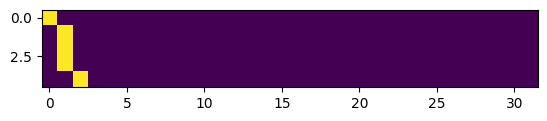

In [47]:
import einops


pe = one_hot_pe # (len, dim)
pos = torch.tensor([ # (batch_size, len)
    [0,1,2,3,4],
    [0,1,1,1,2]
])
pe_extracted = pe[pos]
plt.imshow(pe_extracted[1])

In [49]:
pe.shape, pos.shape

(torch.Size([128, 32]), torch.Size([2, 5]))

In [59]:
from torch.utils.data import DataLoader

pr = ds[0]

def tokenize(pr: Pianoroll, length: int|None=None):
    '''
    token type:
        -1: pad
        0: frame
        1: note
    '''
    current_frame = -1
    tokens = []
    token_types = []
    pos = []
    for note in pr.notes:
        if note.onset > current_frame:
            for _ in range(note.onset - current_frame):
                tokens.append([0,0])
                token_types.append(0)
                pos.append(current_frame)
            current_frame = note.onset
        tokens.append([note.pitch, note.velocity])
        token_types.append(1)
        pos.append(note.onset)
        

    if length is not None and length > len(tokens):
        for _ in range(length - len(tokens)):
            tokens.append([0,0])
            token_types.append(-1)
            pos.append(current_frame)
    tokens = torch.tensor(tokens[:length])
    token_types = torch.tensor(token_types[:length])
    pos = torch.tensor(pos[:length])

    return tokens, token_types, pos


def pad_to_length(x: Tensor, target_length: int, dim: int, pad_value: float):
    padding_shape = list(x.shape)
    padding_shape[dim] = target_length - x.shape[dim]
    return torch.cat([x, torch.full(padding_shape, pad_value)])

def pad_and_stack(batch: list[Tensor], pad_dim: int, pad_value: float=0, stack_dim: int=0, target_length: int|None=None) -> Tensor:
    if target_length is None:
        target_length = max(x.shape[pad_dim] for x in batch)
    return torch.stack([pad_to_length(x, target_length, pad_dim, pad_value) for x in batch], stack_dim)

def collate_fn(batch: list[Pianoroll]):
    tokens_batch = []
    token_types_batch = []
    pos_batch = []
    for pr in batch:
        tokens, token_types, pos = tokenize(pr)
        tokens_batch.append(tokens)
        token_types_batch.append(token_types)
        pos_batch.append(pos)
    tokens_batch = pad_and_stack(tokens_batch, 0)
    token_types_batch = pad_and_stack(token_types_batch, 0)
    pos_batch = pad_and_stack(pos_batch, 0)
    
    return tokens_batch, token_types_batch

dataloader = DataLoader(ds, batch_size=10, collate_fn=collate_fn)


In [58]:
next(iter(dataloader))[0].shape

torch.Size([10, 268, 2])

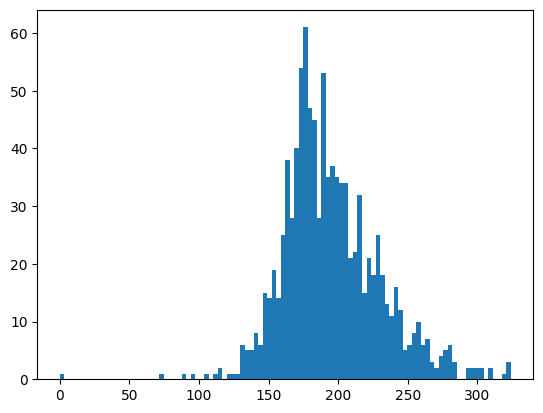